In [1]:
from instrumentdatabaseapi import instrumentdatabaseapi as API
repo = API.Repository(local_repo=".")

In [2]:
print(repo)

URL: https://github.com/PaNOSC-ViNYL/instrument_database.git
local_dir: ./


Load the instrument configuration providing:
 - name of the institute
 - name of the instrument
 - version of the instrument description (HEAD is the most recent)
 - name of the simulation program

In [3]:
#help(repo)

In [4]:
repo.ls_institutes()

 - EuXFEL
 - ILL
 - test_institute


In [5]:
repo.ls_instruments("ILL")
instrument_name="Panther"
instrument_name="ThALES"
instrument_name="IN5"

Available instruments for ILL:
 -  ILL/D22
 -  ILL/Panther
 -  ILL/ThALES
 -  ILL/IN5


In [6]:
repo.ls_versions("ILL",instrument_name)

Available versions for instrument IN5:
 -  HEAD


In [7]:
repo.ls_simulation_programs("ILL",instrument_name,"HEAD")

Instrument IN5 from institute ILL is implemented with the following programs:
 -  mcstas


In [8]:
repo.ls_flavours("ILL",instrument_name,"HEAD","mcstas")

Available flavours for instrument IN5:
 -  None
 -  full
 -  nosection


In [9]:
flavour="full"
#flavour="nosection"

myinstrument = repo.load("ILL", instrument_name, "HEAD", "mcstas", flavour, dep=False)

Chopper0 -> Chopper1 : L = 5.3083
Chopper0 -> Chopper2 : L = 5.4583
Chopper0 -> Chopper3 : L = 12.4289
Chopper0 -> Chopper4 : L = 12.4839
Chopper0 -> Chopper5 : L = 13.2539
Chopper0 -> Chopper6 : L = 13.3089
Chopper0 L=0
Chopper1 L=0
Chopper2 L=0
Chopper3 L=0
Chopper4 L=0
Chopper5 L=0
Chopper6 L=0


In [10]:
myinstrument.list_calculators()

- Instrument: IN5 -
Calculators:
OriginCalc
SampleCalc
DetectorCalc



In [11]:
print(myinstrument)

######## Instrument IN5
- Instrument: IN5 -
Calculators:
OriginCalc
SampleCalc
DetectorCalc
- ParametersCollection object -
  Master Parameters
  speed                               8500                            Rotation frequency of disk choppers RPM   
  ratio                               0.5                                
  lambda                              4.5        [angstrom]              
  nt                                  512                             Number of time channels   
  epchannel                           295                             Elastic peak position in number of channels   

   OriginCalc
    - Parameters object -
   speed                               8500                            Rotation frequency of disk choppers RPM   L[2000, 17000]
   ratio                               0.5                                
   lambda                              4.5        [angstrom]              
   dlambda                             0          [angstrom]  

In [12]:
# setting the base directory for the simulation output
basedir = "/tmp/"+instrument_name+"/"
myinstrument.set_instrument_base_dir(basedir)
import os 
#os.mkdir(basedir)


In [13]:
myinstrument.master

 - Parameters object -
speed                               8500                            Rotation frequency of disk choppers RPM   
ratio                               0.5                                
lambda                              4.5        [angstrom]              
nt                                  512                             Number of time channels   
epchannel                           295                             Elastic peak position in number of channels   

In [14]:
import pint
ureg = pint.get_application_registry()

if instrument_name == "ThALES":
    myinstrument.master["a2"] = myinstrument.energy_to_angle(4.98 * ureg.meV)
    myinstrument.master["a4"] = 60 * ureg.degree
    myinstrument.master["a6"] = myinstrument.master["a2"].pint_value
if instrument_name == "Panther":
    myinstrument.master["energy"]=19 * ureg.meV

In [15]:
myinstrument.samples

['None', 'vanadium', 'H2O', 'D2O', 'sqw']

In [16]:
myinstrument.set_sample_by_name("vanadium")

SPLIT 14 COMPONENT sqw = Isotropic_Sqw(
  Sqw_coh = 0, // [str]
  Sqw_inc = 0, // [str]
  radius = sample_radius, // [m]
  thickness = sample_thickness, // [m]
  xwidth = sample_width, // [m]
  yheight = sample_height, // [m]
  verbose = 2, // [1]
  d_phi = 21.23931055231027, // [deg]
  rho = 0.07232226802632531, // [AA-3]
  sigma_abs = 5.08, // [barns]
  sigma_coh = 0, // [barns]
  sigma_inc = 4.935, // [barns]
  p_interact = 1 // [1]
)
AT (0, 0, 0) RELATIVE sample_arm

In [17]:
myinstrument.sample_cylinder_shape(0.005, 0.01)

In [18]:
myinstrument.sim_neutrons(5e6)
myinstrument.set_seed(654321)
myinstrument.custom_flags("-I mcstas/components")

In [19]:
myinstrument.run()


loading system configuration
INFO: Using directory: "/tmp/IN5/OriginCalc_7"
INFO: Regenerating c-file: OriginCalc.c
CFLAGS= -Wl,-rpath,CMD(mcpl-config --show libdir) -LCMD(mcpl-config --show libdir) -lmcpl -ICMD(mcpl-config --show includedir)
      
-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
INFO: Recompiling: ./OriginCalc.out
./OriginCalc.c: In function ‘class_Monitor_nD_trace’:
./OriginCalc.c:15168:72: warning: unknown conversion type character ‘\x0a’ in format [-Wformat=]
15168 |                 printf("Cylinder_intersect returned unexpected value %l\n", intersect);
      |                                                                        ^~
./OriginCalc.c:15168:24: warning: too many arguments for format [-Wformat-extra-args]
15168 |           


loading system configuration
INFO: Using directory: "/tmp/IN5/SampleCalc_5"
INFO: Regenerating c-file: SampleCalc.c
CFLAGS= -Wl,-rpath,CMD(mcpl-config --show libdir) -LCMD(mcpl-config --show libdir) -lmcpl -ICMD(mcpl-config --show includedir) -Wl,-rpath,CMD(mcpl-config --show libdir) -LCMD(mcpl-config --show libdir) -lmcpl -ICMD(mcpl-config --show includedir)

 The parameter powder_format of sqw is initialized 
 using a static {,,,} vector.
  -> Such static vectors support literal numbers ONLY.
  -> Any vector use of variables or defines must happen via a 
     DECLARE/INITIALIZE pointer.


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 
-> SPLIT N at component sqw

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:
-> SPLIT within buffer at component sqw

-----------------------------------------------------------
INFO: Recompiling: ./SampleCalc.out
./SampleCalc.c: I


loading system configuration
INFO: Using directory: "/tmp/IN5/DetectorCalc_4"
INFO: Regenerating c-file: DetectorCalc.c
Info:    'PSD_Detector' is a contributed component.
CFLAGS= -Wl,-rpath,CMD(mcpl-config --show libdir) -LCMD(mcpl-config --show libdir) -lmcpl -ICMD(mcpl-config --show includedir)
      
 The parameter format of hous is initialized 
 using a static {,,,} vector.
  -> Such static vectors support literal numbers ONLY.
  -> Any vector use of variables or defines must happen via a 
     DECLARE/INITIALIZE pointer.


-----------------------------------------------------------

Generating single GPU kernel or single CPU section layout: 

-----------------------------------------------------------

Generating GPU/CPU -DFUNNEL layout:

-----------------------------------------------------------
INFO: Recompiling: ./DetectorCalc.out
./DetectorCalc.c: In function ‘class_MCPL_input_init’:
./DetectorCalc.c:12400:150: warning: format ‘%lu’ expects argument of type ‘long unsigned i

### Diagnostics of the beam for one calculator

In [20]:
calculator_name="SampleCalc"
calculator_name="OriginCalc"
mycalc = myinstrument.calculators[calculator_name]
#mycalc.backengine()
#myinstrument.run()
#print(mycalc.output)

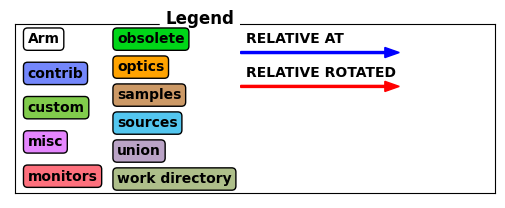

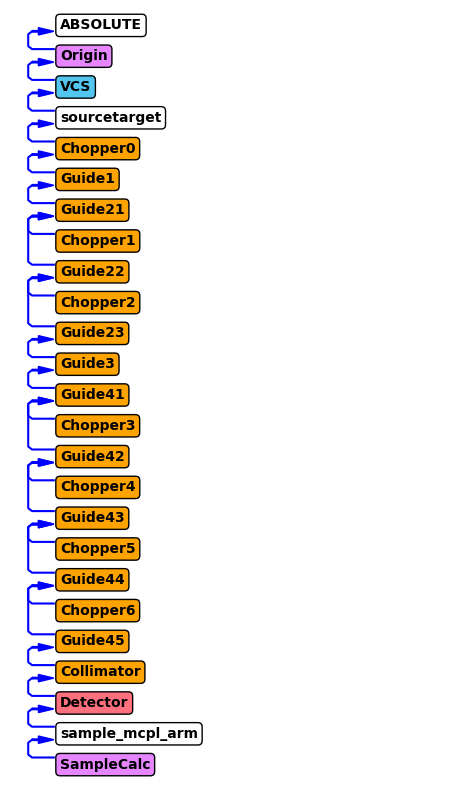

In [21]:
#mycalc = myinstrument.calculators["OriginCalc"]
#mycalc = myinstrument.calculators["SampleCalc"]
#mycalc.input = myinstrument.calculators["OriginCalc"].output
mycalc.show_diagram()


In [22]:
#mycalc.show_diagram(analysis=True, variable="t")

In [23]:
import mcstasscript as ms


In [24]:
diag = ms.Diagnostics(mycalc)
diag.settings(ncount=1e7, suppress_output=True)
diag.show_settings()
diag.clear_points()

elements = []
if len(elements) == 0:
    for component in diag.instr.component_list:
        if component.component_name in ["Progress_bar", "Arm"]:
            continue
        if component.component_name in ["Beamstop"]:
            diag.add_point(before=component.name)
            continue
        elements.append(component.name)
        if component.component_name in ["Chopper0","Chopper1","Chopper2","Chopper3"]:
            diag.add_point(before=component.name)
            diag.add_point(after=component.name)
        else:
            diag.add_point(before=component.name)
        

print(elements)


if mycalc.name == "SampleCalc":
    diag.clear_points()
    diag.add_point(after="Vin")
    diag.add_point(before="sqw")
    diag.add_point(after="Sample_Out")
    diag.add_point(before="after_sample_slit")
    diag.add_point(after="after_sample_slit")

print(diag)


Instrument settings:
  ncount:           1.00e+07
  seed:             654321
  output_path:      /tmp/IN5/OriginCalc
  run_path:         ./
  package_path:     /usr/share/mcstas/3.3
  executable_path:  /usr/share/mcstas/3.3/bin/
  executable:       mcrun
  force_compile:    True
['VCS', 'Chopper0', 'Guide1', 'Guide21', 'Chopper1', 'Guide22', 'Chopper2', 'Guide23', 'Guide3', 'Guide41', 'Chopper3', 'Guide42', 'Chopper4', 'Guide43', 'Chopper5', 'Guide44', 'Chopper6', 'Guide45', 'Collimator', 'Detector', 'SampleCalc']
Instrument diagnostics for: OriginCalc
Diagnostics points: 
  Diagnostics point before: VCS                       - rays: 50000
  Diagnostics point before: Chopper0                  - rays: 50000
  Diagnostics point before: Guide1                    - rays: 50000
  Diagnostics point before: Guide21                   - rays: 50000
  Diagnostics point before: Chopper1                  - rays: 50000
  Diagnostics point before: Guide22                   - rays: 50000
  Diagnostic

In [25]:
#mycalc.get_component("BC1").phase=41
ch = mycalc.get_component("Chopper3")
print(ch)


COMPONENT Chopper3 = DiskChopper(
  theta_0 = 9.5, // [deg]
  radius = 0.299, // [m]
  yheight = 0.081, // [m]
  nu = (speed/60.0 * ratio), // [Hz]
  nslit = 2, // [1]
  delay = 12.4289/neutron_velocity + 0.01 // [s]
)
AT (0, 0, 0.7525000000000001) RELATIVE Guide41


In [26]:
diag.run()

In [27]:
diag.clear_views()
#diag.add_view("t")
#diag.add_view("x", bins=50, limits=[-0.04,0.04])
#diag.add_view("y", bins=50, same_scale=False, limits=[-0.07,0.07])
#diag.add_view("x","y",bins=[30,30])
#diag.add_view("e", same_scale=True)
diag.add_view("l",same_scale=False)
diag.add_view("t",same_scale=False)
#diag.add_view("dx","dy")
diag.add_view("t","x")
diag.add_view("t","y")
diag.add_view("x","y",same_scale=True)
print(diag)

Instrument diagnostics for: OriginCalc
Diagnostics points: 
  Diagnostics point before: VCS                       - rays: 50000 / 50000
  Diagnostics point before: Chopper0                  - rays: 50000 / 50000
  Diagnostics point before: Guide1                    - rays: 50000 / 50000
  Diagnostics point before: Guide21                   - rays: 50000 / 50000
  Diagnostics point before: Chopper1                  - rays: 50000 / 50000
  Diagnostics point before: Guide22                   - rays: 11939 / 50000
  Diagnostics point before: Chopper2                  - rays: 11744 / 50000
  Diagnostics point before: Guide23                   - rays: 11729 / 50000
  Diagnostics point before: Guide3                    - rays: 11646 / 50000
  Diagnostics point before: Guide41                   - rays: 9388 / 50000
  Diagnostics point before: Chopper3                  - rays: 8039 / 50000
  Diagnostics point before: Guide42                   - rays: 8017 / 50000
  Diagnostics point before: Cho

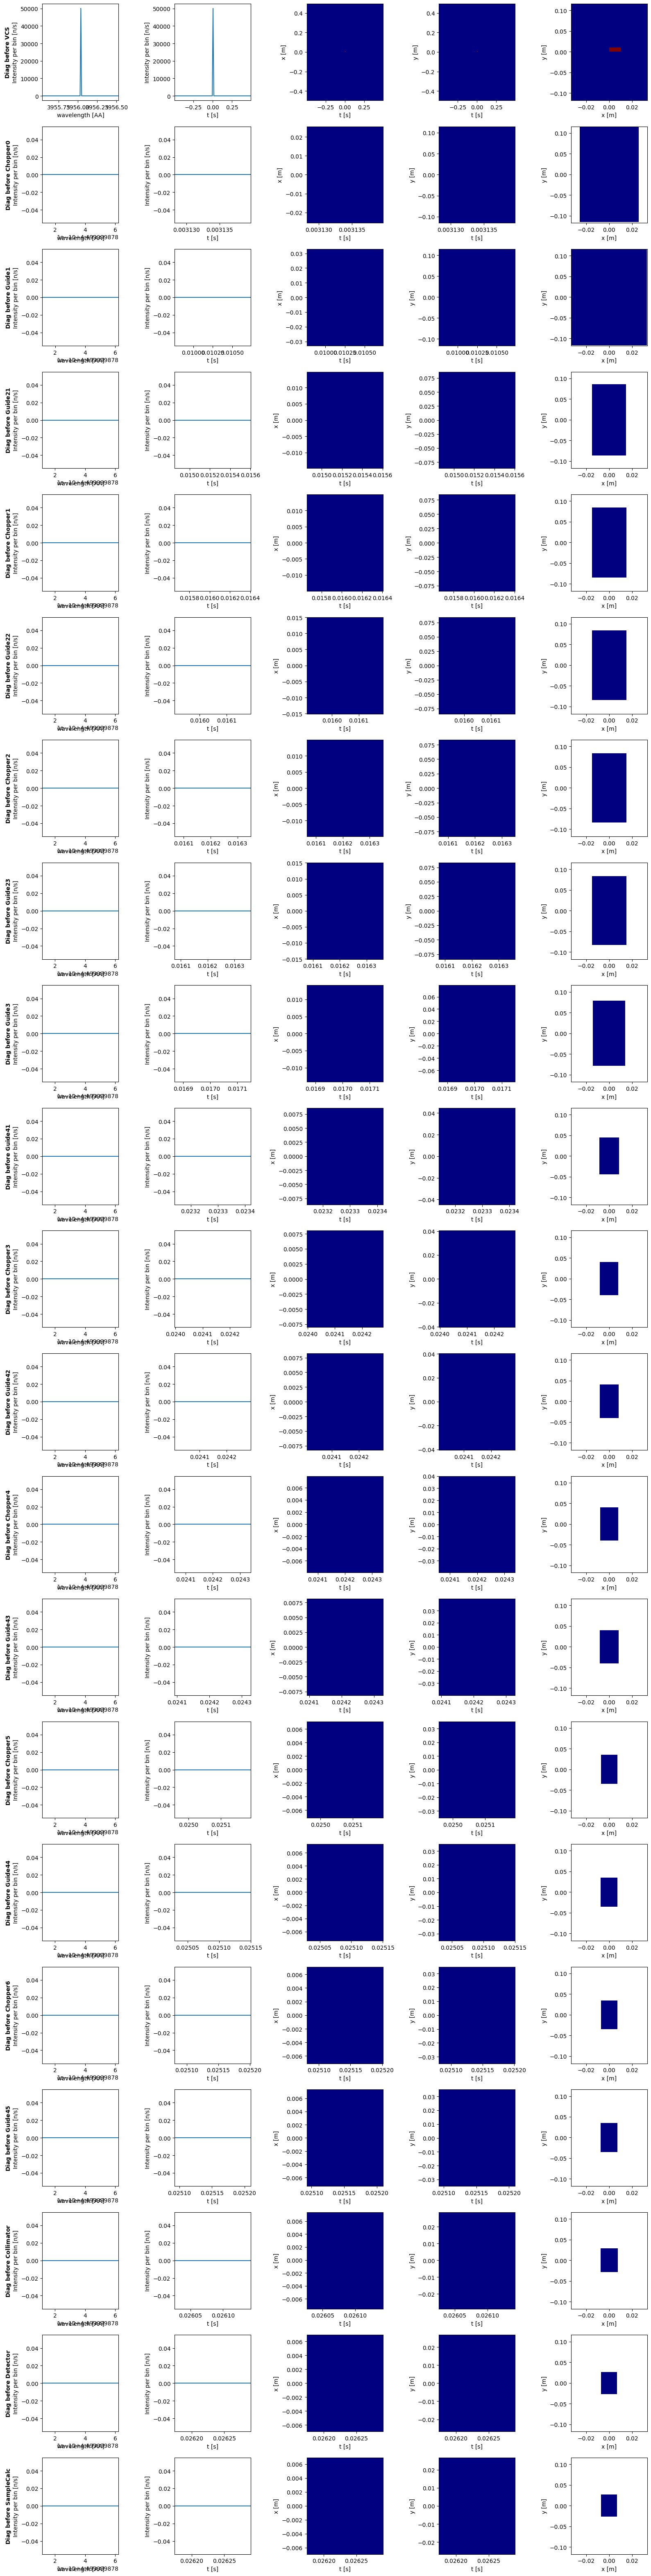

In [28]:
diag.plot()

In [29]:
mycalc.print_component("BC1")
mycalc.print_component("BC2")

#help(mycalc)
mycalc.component_help("DiskChopper")

NameError: No component was found with name "BC1"!

In [ ]:
mycalc.show_instrument()

In [ ]:
ms.make_sub_plot(data_empty[55:59])

In [ ]:
ms.make_sub_plot(data_empty[65:69])

In [ ]:
%matplotlib widget
import mcstasscript.jb_interface as ms_widget
ms_widget.show(data_empty)

In [ ]:
myinstrument.sample.set_SPLIT(60)
myinstrument.sample

In [ ]:
slit=myinstrument.calculators["SampleCalc"].get_component("after_sample_slit")
slit.EXTEND=""
slit.append_EXTEND("if(p<1e-1) ABSORB;")
slit


In [ ]:
myinstrument.run()

In [ ]:
data=myinstrument.output
print(data)
calcname_data="OriginCalc_data"

In [ ]:
print(data[calcname_data])
for detector in data[calcname_data].get_data()["data"]:
    print(detector.Intensity, detector.Error, detector.Ncount)

In [ ]:
(data[calcname_data]).get_data()["data"][0].Intensity

In [ ]:
wmins=["1e-5", "1e-4", "1e-3", "1e-2", "1e-1"]
detectors=[]
for w_min in wmins:
    slit=myinstrument.calculators["SampleCalc"].get_component("after_sample_slit")
    slit.EXTEND=""
    slit.append_EXTEND(f"if(p<{w_min}) ABSORB;")
    myinstrument.run()
    data=myinstrument.output
    detector=(data["DetectorCalc_data"].get_data()["data"][0])
    detectors.append(detector)

In [ ]:
detectors

In [ ]:
import numpy as np
diags = []
RHs = list(np.arange(2.6,4,0.3))
RVs = list(np.arange(1,3,0.3))
RVs.append(1.88)
RHs.append(3.31)
print(RHs)
print(RVs)

In [ ]:
for RH in RHs:
    print(RH)
    mycalc.parameters["RHmono"]=RH
    diag = ms.Diagnostics(mycalc)
    diag.settings(ncount=1e6, suppress_output=True,force_compile=False)
    diag.clear_points()
    diag.add_point(after="before_sample_slit")
#    diag.add_point(before="sqw")
    diag.run()
    diags.append(diag)

#(RHmono,RVmono) = (3.31,1.88)
#lambda: 4.05
#lambda: 4.05 +/- 0.04
#energy: 4.98 +/- 0.10
#(RHanalyzer,RVanalyzer) = (4.17,0.77)
#'Monochromator', 'counter', 'before_sample_slit', 'sqw', 'after_sample_slit', 'analyzer', 'slit', 'detector_all']

In [ ]:
for diag in diags:
    diag.clear_views()
    diag.add_view("x", bins=50, limits=[-0.04,0.04])
    diag.add_view("y", bins=50, same_scale=False, limits=[-0.07,0.07])
    #diag.add_view("x","y",bins=[30,30])
    #diag.add_view("dx","dy")
    diag.add_view("dx")
    diag.add_view("dy")
    diag.plot()

In [ ]:
RVdiags = []


print(RVs)
for RV in RVs:
    print(RV)
    mycalc.parameters["RVmono"]=RV
    diag = ms.Diagnostics(mycalc)
    diag.settings(ncount=1e6, suppress_output=True,force_compile=False)
    diag.clear_points()
    diag.add_point(after="before_sample_slit")
#    diag.add_point(before="sqw")
    diag.run()
    RVdiags.append(diag)

In [ ]:
for diag in RVdiags:
    diag.clear_views()
    diag.add_view("x", bins=50, limits=[-0.04,0.04])
    diag.add_view("y", bins=50, same_scale=False, limits=[-0.07,0.07])
    #diag.add_view("x","y",bins=[30,30])
    #diag.add_view("dx","dy")
    diag.add_view("dx")
    diag.add_view("dy")
    diag.plot()

In [ ]:
myinstrument.force_compile(False)
myinstrument.sim_neutrons(1e5)
counter=[]
detector=[]
mycalc = myinstrument.calculators["OriginCalc"]
for RV in RVs:
    for RH in RHs:
        mycalc.parameters["RHmono"].value = RH
        mycalc.parameters["RVmono"].value = RV
        #print(mycalc.parameters)
        myinstrument.run()
        counter.append(myinstrument.output["OriginCalc_data"].get_data()["data"])

In [ ]:
i=0
i_det=1
for RV in RVs:
    for RH in RHs:
        c = counter[i]
        det=c[1]
        print(i, "\t" , RV, RH, "\t\t" , det.Intensity, det.Error, det.Ncount)
        i=i+1

In [ ]:
mycalc.output

In [ ]:
print(myinstrument.output)

In [ ]:
RHs = list(np.arange(1.5,3,0.2))
RVs = list(np.arange(0.3,1.2,0.2))
RVs.append(0.51)
RHs.append(1.41)
print(RHs)
print(RVs)

myinstrument.force_compile(False)
myinstrument.sim_neutrons(1e5)
counter=[]

mycalc = myinstrument.calculators["OriginCalc"]
for RV in RVs:
    for RH in RHs:
        mycalc.parameters["RHanalyzer"].value = RH
        mycalc.parameters["RVanalyzer"].value = RV
        #print(mycalc.parameters)
        myinstrument.run()
        counter.append(myinstrument.output["OriginCalc_data"].get_data()["data"])

In [ ]:
i=0
i_det=1
intensities = []
counts = []
for RV in RVs:
    for RH in RHs:
        c = counter[i]
        det=c[1]
        #print(i, "\t" , RV, RH, "\t\t" , det.Intensity, det.Error, det.Ncount)
        intensities.append(det.Intensity)
        counts.append(det.Ncount)
        i=i+1

In [ ]:
max(intensities)

In [ ]:
max(counts)

In [ ]:
intensities.index(max(intensities))

In [ ]:
counts.index(max(counts))

In [ ]:
i=0
for RV in RVs:
    for RH in RHs:
        print(RV, RH, counts[i])
        if i==counts.index(max(counts)):
            print("---> ",RV, RH)
        i=i+1

In [ ]:
RVs

In [ ]:
RHs

In [ ]:
dist_sample_ana = 1.260
dist_ana_det = 0.640
import math
ana_focus = 1.0 / (1.0 / dist_sample_ana + 1.0 / dist_ana_det)

In [ ]:

def rh(ana_focus):
    return 2*ana_focus/math.sin(math.pi/180*myinstrument.master["a6"].value/2)
def rv(ana_focus):
    return 2*ana_focus*math.sin(math.pi/180*myinstrument.master["a6"].value/2)


In [ ]:
print(rv(ana_focus),rh(ana_focus))

In [ ]:
ana_focus=dist_ana_det
print(rv(ana_focus),rh(ana_focus))